# NB 15b:  MLR Model Selection


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from patsy import dmatrices
import seaborn as sns
from IPython.display import Image



In [119]:
#For this notebook we'll use a built-in dataset available in Python called mtcars
cars= sm.datasets.get_rdataset('mtcars').data

## Practice with Model Selection.

In general, model selection is an "art" not a science.

There is not usually "ONE" correct/best model.  It all depends on how you are measuring best and what you are using the model for. 


We're going to go through an example of this with the cars datset.

For another great example with more details of this see:https://online.stat.psu.edu/stat501/lesson/10/10.4




### Part 1: Predictor Selection:  Visualizations and Collinearity:

What do we see?

A data frame with 32 observations on 11 (numeric) variables.

- mpg	Miles/(US) gallon
- cyl	Number of cylinders
- disp	Displacement (cu.in.)
- hp	Gross horsepower
- drat	Rear axle ratio
- wt	Weight (1000 lbs)
- qsec	1/4 mile time
- vs	Engine (0 = V-shaped, 1 = straight)
- am	Transmission (0 = automatic, 1 = manual)
- gear	Number of forward gears
- carb	Number of carburetors

**GOAL:** predict the milage of a car given its other descriptors/features.

                    mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
Mazda RX4          21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
Mazda RX4 Wag      21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
Datsun 710         22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
Hornet 4 Drive     21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

                   carb  
Mazda RX4             4  
Mazda RX4 Wag         4  
Datsun 710            1  
Hornet 4 Drive        1  
Hornet Sportabout     2  


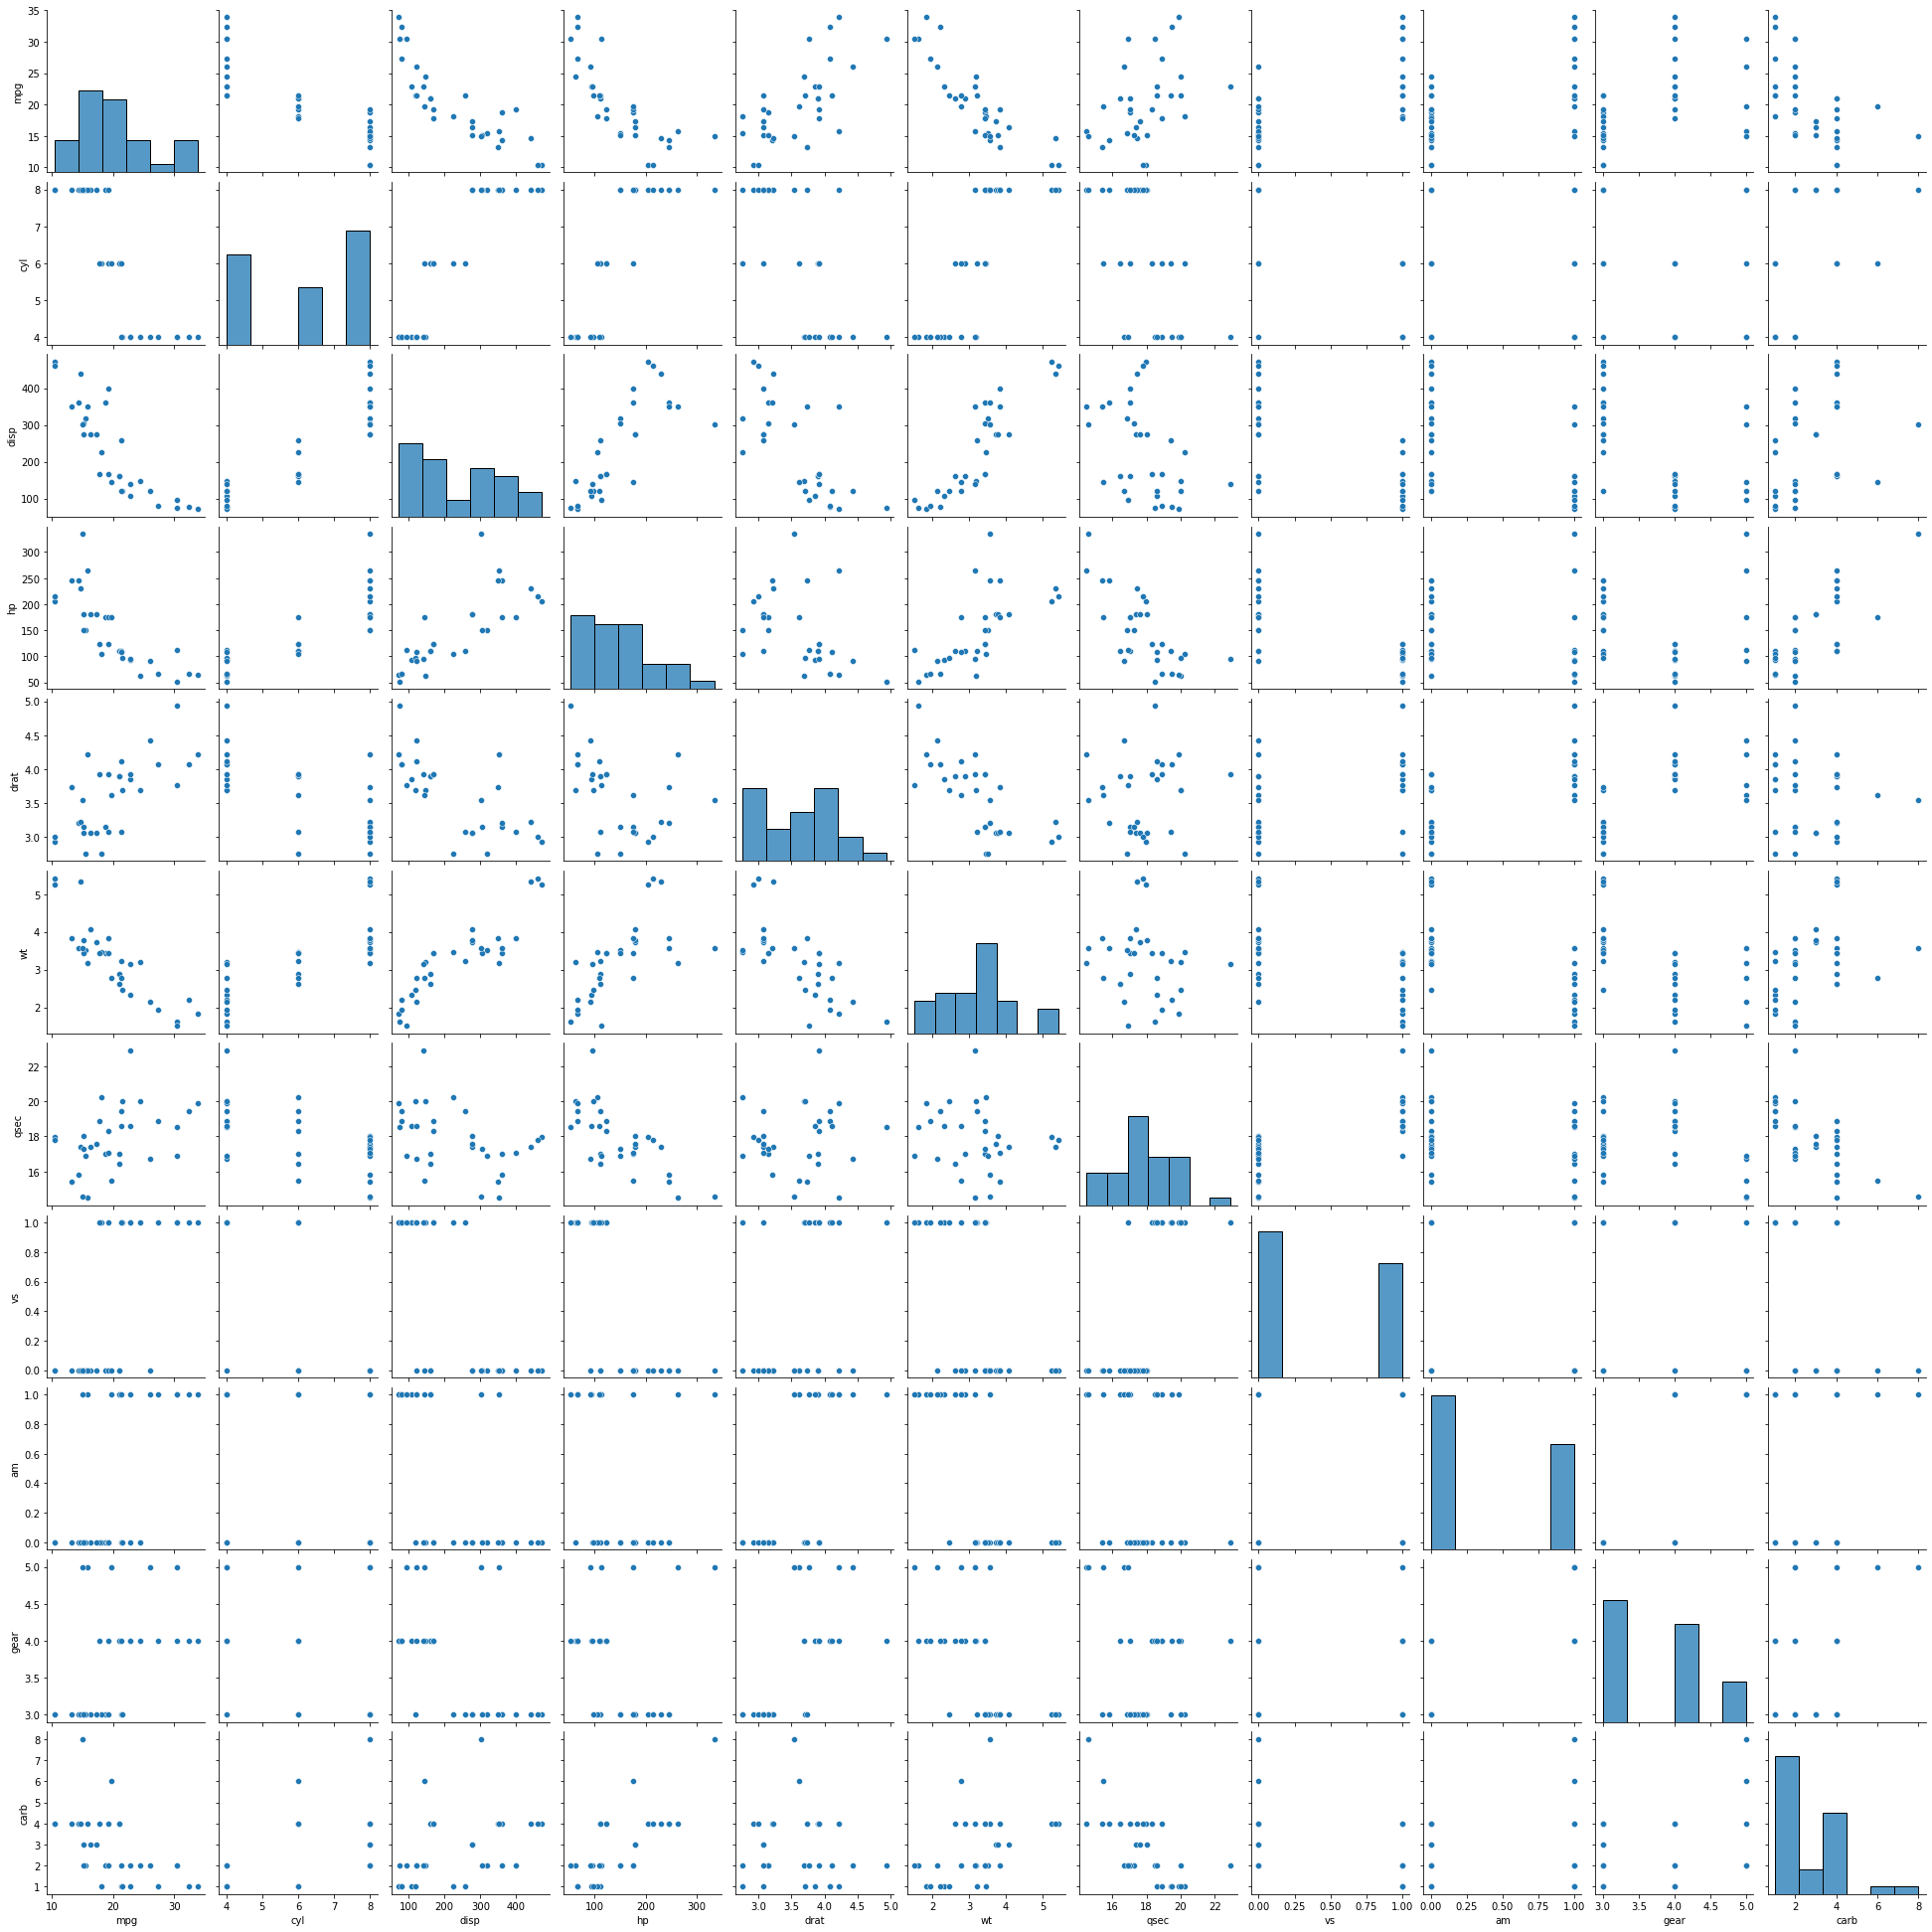

In [120]:

print(cars.head())
sns.pairplot(cars)


Two big intuitions:

1. Since this is only 32 observations and 11 columns, we will want to reduce the number of predictors to avoid overfitting.  Having nearly 1/3 as many features as you have observations is pretty high!  A lean model might want at most 5?

2. At a glance, many feature are related.  See e.g. row/column 2: cylinder seems somewhat related to all of the other features.  We see numerous other similarities: weight to horsepower, etc.



In [121]:
cars.corr()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
mpg,1.000000,-0.852162,-0.847551,-0.776168,0.681172,-0.867659,0.418684,0.664039,0.599832,0.480285,-0.550925
cyl,-0.852162,1.000000,0.902033,0.832447,-0.699938,0.782496,-0.591242,-0.810812,-0.522607,-0.492687,0.526988
disp,-0.847551,0.902033,1.000000,0.790949,-0.710214,0.887980,-0.433698,-0.710416,-0.591227,-0.555569,0.394977
hp,-0.776168,0.832447,0.790949,1.000000,-0.448759,0.658748,-0.708223,-0.723097,-0.243204,-0.125704,0.749812
drat,0.681172,-0.699938,-0.710214,-0.448759,1.000000,-0.712441,0.091205,0.440278,0.712711,0.699610,-0.090790
wt,-0.867659,0.782496,0.887980,0.658748,-0.712441,1.000000,-0.174716,-0.554916,-0.692495,-0.583287,0.427606
qsec,0.418684,-0.591242,-0.433698,-0.708223,0.091205,-0.174716,1.000000,0.744535,-0.229861,-0.212682,-0.656249
vs,0.664039,-0.810812,-0.710416,-0.723097,0.440278,-0.554916,0.744535,1.000000,0.168345,0.206023,-0.569607
am,0.599832,-0.522607,-0.591227,-0.243204,0.712711,-0.692495,-0.229861,0.168345,1.000000,0.794059,0.057534
gear,0.480285,-0.492687,-0.555569,-0.125704,0.699610,-0.583287,-0.212682,0.206023,0.794059,1.000000,0.274073


In [115]:
#We definitely want to remove some things.  Here's what a "full" model would look like


y, X = dmatrices('mpg ~ cyl+disp+hp+drat+wt+qsec+vs+am+gear+carb', data=cars, return_type='dataframe')
carslmfull=sm.OLS(y,X).fit()
print(carslmfull.summary())



                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.93
Date:                Mon, 01 May 2023   Prob (F-statistic):           3.79e-07
Time:                        14:18:11   Log-Likelihood:                -69.855
No. Observations:                  32   AIC:                             161.7
Df Residuals:                      21   BIC:                             177.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3034     18.718      0.657      0.5


There are two places that the collinarity shows up above.  First, note the warning number [2] at the bottom.  The condition number is a numeric property of the matrix $X^TX$ that serves to measure its linear dependence: and how easy it is to invert, numerically!  High is very bad here. 

Second, notice how *despite* a high-sh $R^2$ and $F$ significance, none of the individual columns look useful.  That's a sign that their redundancy is making them confuse one another.



## Model Selection

We have some options here.  

Option 1:  We can start by trying to eliminate the columns with the highest **variance inflation factor** (VIF).   Note that VIF measures the multiple by which our overall uncertainties are changing because of the presence of that predictor. (see nb 15 for an example of approaching this problem examining VIF first).  

Option 2:  Or since we only have 10 predictors, we can start with a brute force method that looks at all of the combinations of variables and see which one(s) give us the highest adjusted R^2 (and then eliminate from there).


#### Model Selection Using Adjusted $R^2$

In [122]:
#In our case, because we only have 10 predictor variables, we can look through all combinations of variables and see which model has the highest adjusted R^2:
#Start by looking at which combination of variables leads to the highest R^2:

independent_variables = cars.drop('mpg' , axis=1).columns


from itertools import combinations

# https://stackoverflow.com/questions/4074991/generate-all-permutations-of-all-lengths
variable_combinations = [list(combo) for i in range(1, len(independent_variables) + 1) for combo in combinations(independent_variables, i) ]
adjusted_r2 = []
y = cars['mpg']

for variable_combo in variable_combinations: 
    
    X = cars[variable_combo]
    X = sm.add_constant(X)
    model = sm.OLS(y , X).fit()
    adjusted_r2.append((variable_combo , model.rsquared_adj))

print('Variables' , '===>\t' , 'Adjusted R^2 Score' )
    
for variables, adj_r2_score in sorted(adjusted_r2 , key=lambda x : x[1] , reverse=True) : 
    print(variables , '===>\t' , adj_r2_score)

Variables ===>	 Adjusted R^2 Score
['disp', 'hp', 'wt', 'qsec', 'am'] ===>	 0.8375333831347977
['hp', 'wt', 'qsec', 'am'] ===>	 0.8367919107753032
['wt', 'qsec', 'am', 'carb'] ===>	 0.8355851562601458
['disp', 'hp', 'drat', 'wt', 'qsec', 'am'] ===>	 0.8347177288161661
['disp', 'hp', 'wt', 'qsec', 'am', 'gear'] ===>	 0.8343134168014517
['drat', 'wt', 'qsec', 'am', 'carb'] ===>	 0.8340242247938325
['hp', 'wt', 'qsec', 'am', 'carb'] ===>	 0.8339317658788536
['cyl', 'disp', 'hp', 'wt', 'qsec', 'am'] ===>	 0.8337290100664532
['wt', 'qsec', 'am'] ===>	 0.8335560802576044
['wt', 'qsec', 'am', 'gear', 'carb'] ===>	 0.83231705119828
['disp', 'hp', 'wt', 'qsec', 'vs', 'am'] ===>	 0.8322689479494983
['hp', 'drat', 'wt', 'qsec', 'am'] ===>	 0.8320265431164591
['cyl', 'wt', 'qsec', 'am', 'carb'] ===>	 0.8319158149315521
['hp', 'drat', 'wt', 'qsec', 'am', 'carb'] ===>	 0.8311391960157711
['disp', 'hp', 'wt', 'qsec', 'am', 'carb'] ===>	 0.8310473013909481
['cyl', 'hp', 'wt', 'qsec', 'am'] ===>	 0.830

### Let's examine the "best" Adjusted R^2 model:

In [123]:
y, X = dmatrices('mpg ~ disp+hp+wt+qsec+am', data=cars, return_type='dataframe')
carslm1=sm.OLS(y,X).fit()
print(carslm1.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     32.96
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.84e-10
Time:                        14:20:59   Log-Likelihood:                -70.487
No. Observations:                  32   AIC:                             153.0
Df Residuals:                      26   BIC:                             161.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.3619      9.741      1.474      0.1

### Which variables to remove when there's collinearity?

Notice that disp and hp both have p-values that are greater than 0.05, indicating there might be some collinearity.  
We also have a high condition number here.

We can see from the correlation matrix that disp is highly correlated with many of the other variables. 

In [124]:
X.corr()

,Intercept,disp,hp,wt,qsec,am
Intercept,NaN,NaN,NaN,NaN,NaN,NaN
disp,NaN,1.000000,0.790949,0.887980,-0.433698,-0.591227
hp,NaN,0.790949,1.000000,0.658748,-0.708223,-0.243204
wt,NaN,0.887980,0.658748,1.000000,-0.174716,-0.692495
qsec,NaN,-0.433698,-0.708223,-0.174716,1.000000,-0.229861
am,NaN,-0.591227,-0.243204,-0.692495,-0.229861,1.000000


One classic score for *which* variables to remove first is the **variance inflation factor**.  For each predictor, it measures the multiple by which our overall uncertainties are changing because of the presence of that predictor.


In [125]:
for i in range(X.shape[1]):
    print('VIF for ', X.columns[i], ' ', variance_inflation_factor(X.values, i))

VIF for  Intercept   514.4933179617775
VIF for  disp   9.071960267921225
VIF for  hp   5.195144396303569
VIF for  wt   7.1708021157544
VIF for  qsec   3.791425934958867
VIF for  am   2.887333886644994


#### If there are still predictors that are correlated or aren't statistically signficant remove largest offending predictor, repeat.

In [126]:
y, X = dmatrices('mpg ~ hp+wt+qsec+am', data=cars, return_type='dataframe')
carslm2=sm.OLS(y,X).fit()
print(carslm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     40.74
Date:                Mon, 01 May 2023   Prob (F-statistic):           4.59e-11
Time:                        14:21:03   Log-Likelihood:                -71.164
No. Observations:                  32   AIC:                             152.3
Df Residuals:                      27   BIC:                             159.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.4402      9.319      1.871      0.0

This reduced our condition number, so that's good sign.  We see that 'hp' is still not statistically significant when we take into account the other variables in the model.

In [127]:
for i in range(X.shape[1]):
    print('VIF for ', X.columns[i], ' ', variance_inflation_factor(X.values, i))

VIF for  Intercept   468.7483946722271
VIF for  hp   4.922128878459751
VIF for  wt   3.9645146666752797
VIF for  qsec   3.2160214960949403
VIF for  am   2.5415266398534784


### Partial F- Test:

This is also a good time to try a partial F-test. We could compare the lm1 model  to one with disp and hp removed (since they had p-values that were not significantly different than 0 when we used the t-test).  

$H_0:  disp=0$ and $hp=0$

$H_A:$  At least one is non-zero


In [128]:
#Note: We can also use a Partial F-Test here, to see what happens as we remove multiple variables at once

hypotheses = '(disp = 0), (hp= 0)'
f_test = carslm1.f_test(hypotheses)
print(f_test)

<F test: F=1.3427303488870148, p=0.27864403100920543, df_denom=26, df_num=2>


This p-value is large, allowing us to NOT reject the null that both may be 0.  This gives us a good reason to remove them both from the model.

### Remove next largest offending predictor, repeat.

In [77]:
#removed hp
y, X = dmatrices('mpg ~ wt+qsec+am', data=cars, return_type='dataframe')
carslmfinal=sm.OLS(y,X).fit()
print(carslm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.75
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.21e-11
Time:                        13:10:03   Log-Likelihood:                -72.060
No. Observations:                  32   AIC:                             152.1
Df Residuals:                      28   BIC:                             158.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6178      6.960      1.382      0.1

In [76]:
#This looks better!  Our condition number is much smallar, let's check the VIFs.  

In [78]:
for i in range(X.shape[1]):
    print('VIF for ', X.columns[i], ' ', variance_inflation_factor(X.values, i))

VIF for  Intercept   256.3626961990865
VIF for  wt   2.482951505173057
VIF for  qsec   1.364339141336286
VIF for  am   2.541437244495401


Well, we're down to 3 features and while the VIFs are still kind of high on average (we're ideally looking for an average below 1), removing the variables has led to us barely losing anything in the adjusted $R^2$.  So let's inspect this model further.

# Part 2: Assumption Checks

## 2a: Normality:

Two plots here: a histogram for visually assessing normality ("is is bell-like?") and a QQplot:("are the quantiles normal-like?")

(array([4., 3., 5., 5., 3., 4., 2., 1., 2., 3.]),
 array([-3.481067  , -2.66686047, -1.85265394, -1.03844742, -0.22424089,
         0.58996564,  1.40417216,  2.21837869,  3.03258522,  3.84679174,
         4.66099827]),
 <BarContainer object of 10 artists>)

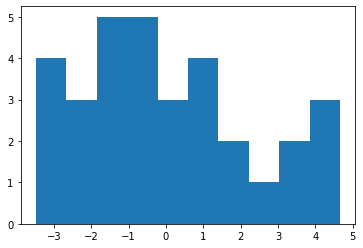

In [79]:
plt.hist(carslmfinal.resid)


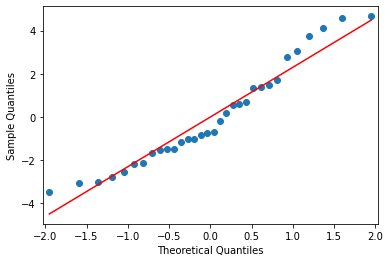

In [80]:
sm.qqplot(carslmfinal.resid, stats.t, distargs=(len(y)-2,), line='s');

### Normality Results:

This doesn't look look great, mainly because of a high skew. 

If we look at the Prob(Omnibus): 0.276, this is the probability that the residuals are normally distributed.  (We want this close to 1).  

It's a sign to be careful about outliers, maybe.  (If a few points are way off, they end up as extreme negative/positive residuals, and extreme outcomes are supposed to be very rare with normals.  So if we see big misses on 31 data points, they show up on our QQ plot as points way-off-the-line).

It's also a sign that we may want to try adding in other types of parameters (maybe squaring a variable, etc)

Confidence bands for the mean are pretty robust to normality issues, but we should proceed with caution if want to use prediction intervals with this data.
 

## Residuals, Model Goodness:

Two major plots here:
- y against the fitted values for an overall view of goodness of fit.  We're looking for a linear relationship with slope 1 and intercept (0).  
- FOR EACH PREDICTOR x: x against residuals.  Looking for patterns in the residuals: +/- clumping (non-independence) but also fanning out (heteroskedasticity).

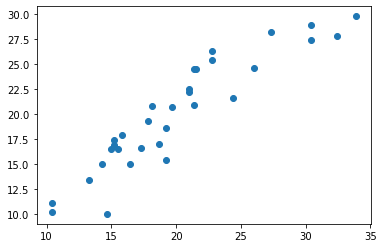

In [82]:
plt.scatter(cars['mpg'], carslmfinal.fittedvalues)

Our fit isn't too bad!  But it does look like it might be concave down: those larger $y$ values look like a bit of an issue.  We may want to examine if one or more $X$ values might let us capture those fits.

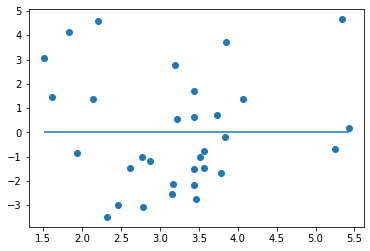

In [84]:
#reminder of modeL: mpg ~ wt+qsec+am'
plt.scatter(cars['wt'], carslmfinal.resid)
plt.hlines(0, xmin=min(cars['wt']), xmax=max(cars['wt']))
#This plot looks good - it's randomly scattered around 0.  

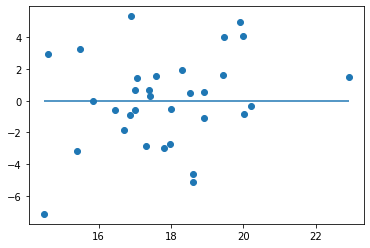

In [86]:
#reminder of modeL: 'mpg ~ wt+qsec+am'
plt.scatter(cars['qsec'], carslm.resid)
plt.hlines(0, xmin=min(cars['qsec']), xmax=max(cars['qsec']))
# looks great!  You can see our big outlier here: it's a big miss on one of the slowest cars!

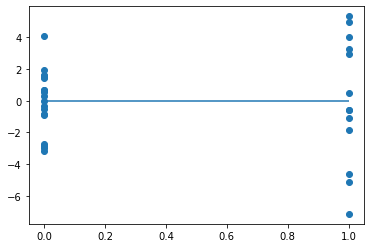

In [87]:
#reminder of modeL: 'mpg ~ wt+qsec+am'
plt.scatter(cars['am'], carslm.resid)
plt.hlines(0, xmin=min(cars['am']), xmax=max(cars['am']))
# #definitely higher spread and variance on am=1.  We could test this and report:
#the manual transmission cars have higher spread in mileage.

### Wrapup!

These plots are indicating we might want to explore other nonlinear predictors and/or models.  But for the scope of our class, this is a sufficient model because:

 - The adjusted R^2 is relatively high compared to our highest possible
 - Our F p-value is significant
 - We only kept variables that were statistically significant based on the t-tests.  
 - This led us to a relatively simple model with variables that passed sanity checks.



 We did a model and we validated it.  

In [89]:
carslmfinal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.75
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.21e-11
Time:                        13:16:03   Log-Likelihood:                -72.060
No. Observations:                  32   AIC:                             152.1
Df Residuals:                      28   BIC:                             158.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6178      6.960      1.382      0.178      -4.638      23.874
wt            -3.9165      0.711     -5.507      0.000      -5.373      -2.460
qsec           1.2259      0.289      4.247      0.000       0.635       1.817
am             2.9358      1.411      2.081      0.047       0.046       5.826
==============================================================================
Omnibus:                        2.574   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                2.213
Skew:                           0.540   Prob(JB):                        0.331
Kurtosis:                       2.297   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$MPG = 9.6178+ wt(-3.9165)+ qsec*(1.2259) +am(2.9358)$



## Other Model Selection Approaches:

VIF pre-selection (see NB 15)

We could use a selection scheme instead.  Compare ALL the models:

- mpg~cyl
- mpg~disp
- mpg~hp
- mpg~drat
- mpg~wt)
- mpg~qsec
- mpg~vs
- mpg~am
- mpg~gear
- mpg~carb

and then add the one that represents the biggest jump in adjusted $R^2$.  We then naturally won't add any colinear predictors, since we've laready described that variable!



In [97]:
independent_variables = cars.drop('mpg' , axis=1).columns


#from itertools import combinations

# https://stackoverflow.com/questions/4074991/generate-all-permutations-of-all-lengths
#variable_combinations = [list(combo) for i in range(1, len(independent_variables) + 1) for combo in combinations(independent_variables, i) ]
adjusted_r2 = []
y = cars['mpg']

for variable_combo in independent_variables: 
    
    X = cars[variable_combo]
    X = sm.add_constant(X)
    model = sm.OLS(y , X).fit()
    adjusted_r2.append((variable_combo , model.rsquared_adj))

print('Variables' , '===>\t' , 'Adjusted R^2 Score' )
    
for variables, adj_r2_score in sorted(adjusted_r2 , key=lambda x : x[1] , reverse=True) : 
    print(variables , '===>\t' , adj_r2_score)
    


Variables ===>	 Adjusted R^2 Score
wt ===>	 0.7445938867802067
cyl ===>	 0.7170526719302649
disp ===>	 0.7089547851727209
hp ===>	 0.5891852528047319
drat ===>	 0.44612834025125603
vs ===>	 0.42231260898667977
am ===>	 0.3384589082063141
carb ===>	 0.28030238495624393
gear ===>	 0.20502922973643123
qsec ===>	 0.14780619760304659


In [98]:
X = cars['wt']
X = sm.add_constant(X)
model = sm.OLS(y , X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     91.38
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.29e-10
Time:                        13:56:50   Log-Likelihood:                -80.015
No. Observations:                  32   AIC:                             164.0
Df Residuals:                      30   BIC:                             167.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.2851      1.878     19.858      0.000      33.450      41.120
wt            -5.3445      0.559     -9.559      0.000      -6.486      -4.203
==============================================================================
Omnibus:                        2.988   Durbin-Watson:                   1.252
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.399
Skew:                           0.668   Prob(JB):                        0.301
Kurtosis:                       2.877   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
#Add weight:

independent_variables = cars.drop('mpg', axis=1).columns
independent_variables = cars.drop('wt', axis=1).columns

#from itertools import combinations

# https://stackoverflow.com/questions/4074991/generate-all-permutations-of-all-lengths
#variable_combinations = [list(combo) for i in range(1, len(independent_variables) + 1) for combo in combinations(independent_variables, i) ]

variable_combinations=[]

for name in independent_variables:
    if name !='mpg':
        variable_combinations.append(['wt',name])

#print(variable_combinations)

adjusted_r2 = []
y = cars['mpg']

for variable_combo in variable_combinations: 
    
    X = cars[variable_combo]
    X = sm.add_constant(X)
    model = sm.OLS(y , X).fit()
    adjusted_r2.append((variable_combo , model.rsquared_adj))

print('Variables' , '===>\t' , 'Adjusted R^2 Score' )
    
for variables, adj_r2_score in sorted(adjusted_r2 , key=lambda x : x[1] , reverse=True) : 
    print(variables , '===>\t' , adj_r2_score)


Variables ===>	 Adjusted R^2 Score
['wt', 'cyl'] ===>	 0.8185189376969552
['wt', 'hp'] ===>	 0.8148396209781563
['wt', 'qsec'] ===>	 0.8144448257767618
['wt', 'vs'] ===>	 0.7872659070462518
['wt', 'carb'] ===>	 0.7781281499718434
['wt', 'disp'] ===>	 0.7658223459116572
['wt', 'drat'] ===>	 0.7444071060200104
['wt', 'gear'] ===>	 0.7368660542605248
['wt', 'am'] ===>	 0.735788906182185


In [100]:
y, X = dmatrices('mpg ~ wt+cyl', data=cars, return_type='dataframe')
carslm3=sm.OLS(y,X).fit()
print(carslm3.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     70.91
Date:                Mon, 01 May 2023   Prob (F-statistic):           6.81e-12
Time:                        13:56:53   Log-Likelihood:                -74.005
No. Observations:                  32   AIC:                             154.0
Df Residuals:                      29   BIC:                             158.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.6863      1.715     23.141      0.0

In [101]:
#Add cyl:

independent_variables = cars.drop('mpg', axis=1).columns
independent_variables = cars.drop('wt', axis=1).columns
independent_variables = cars.drop('cyl', axis=1).columns

#from itertools import combinations

# https://stackoverflow.com/questions/4074991/generate-all-permutations-of-all-lengths
#variable_combinations = [list(combo) for i in range(1, len(independent_variables) + 1) for combo in combinations(independent_variables, i) ]

variable_combinations=[]

for name in independent_variables:
    if name !='mpg':
        variable_combinations.append(['wt','cyl',name])

#print(variable_combinations)

adjusted_r2 = []
y = cars['mpg']

for variable_combo in variable_combinations: 
    
    X = cars[variable_combo]
    X = sm.add_constant(X)
    model = sm.OLS(y , X).fit()
    adjusted_r2.append((variable_combo , model.rsquared_adj))

print('Variables' , '===>\t' , 'Adjusted R^2 Score' )
    
for variables, adj_r2_score in sorted(adjusted_r2 , key=lambda x : x[1] , reverse=True) : 
    print(variables , '===>\t' , adj_r2_score)


Variables ===>	 Adjusted R^2 Score
['wt', 'cyl', 'hp'] ===>	 0.8263446243339773
['wt', 'cyl', 'carb'] ===>	 0.8255786744553772
['wt', 'cyl', 'qsec'] ===>	 0.8224274554212465
['wt', 'cyl', 'wt'] ===>	 0.8185189376969552
['wt', 'cyl', 'gear'] ===>	 0.815014783473566
['wt', 'cyl', 'disp'] ===>	 0.8146720714054781
['wt', 'cyl', 'vs'] ===>	 0.8127315624865467
['wt', 'cyl', 'am'] ===>	 0.8121602799343484
['wt', 'cyl', 'drat'] ===>	 0.812038477654704


In [102]:
y, X = dmatrices('mpg ~ wt+cyl+hp', data=cars, return_type='dataframe')
carslm3=sm.OLS(y,X).fit()
print(carslm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     50.17
Date:                Mon, 01 May 2023   Prob (F-statistic):           2.18e-11
Time:                        13:56:56   Log-Likelihood:                -72.738
No. Observations:                  32   AIC:                             153.5
Df Residuals:                      28   BIC:                             159.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.7518      1.787     21.687      0.0

In this case, since cyl and hp are now not statistically significant with their t-tests, we may decide to stop with just the previous version of the model (using wt and cyl)